In [5]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import deque
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In the above, I'm downloading the CIFAR data set. This is a set of 32x32 pixel RGB images, belonging to the 10 classes indicated. The ToTensor() transformation here is necessary to convert the original data from image objects to numerical arrays that we can process.

In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

The training data set consists of 50,000 32x32 images, each pixel consisting of three values (RGB). The three values are generally referred to as the `channels' of the data. A black and white image could be thought of as having a single channel.

In [ ]:
trainset.targets[0:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

The targets, the first 10 of which are shown here, are class labels, 0 through 9, corresponding to the indices in the classes list above.

In [ ]:
classes[ trainset.targets[0] ]

'frog'

We see that the first image in the training set is labeled as a frog.

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
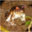

In [ ]:
trainset.data[0]

COLAB prints out a tiny thumbnail here, which I think is interesting, but more importantly we see that the image data is stored as a numpy array, 32x32x3, where each value is an integer between 0 and 255.

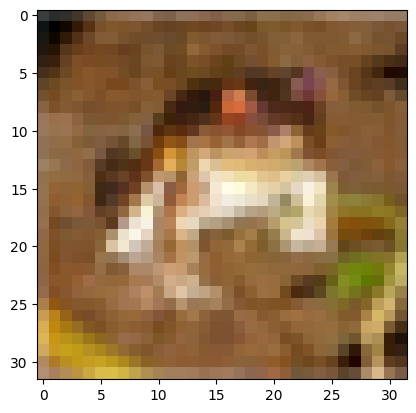

In [ ]:
plt.imshow( trainset.data[0] / 256 )
plt.show()

In the following code block, I prepare the data for use - the first step is to scale all the pixel values to be between 0 and 1, by dividing by 255. Next, I subtract off 0.5, so that pixel values are centered [-0.5, 0.5] rather than [0, 255] as before.

Two important technical notes here:

First, the implementation of convolutional layers in PyTorch expects the data to be presented 'channel first', that is a tensor of data should be of the form [ batch_size, num channels, height, width ]. As such, I use the permute function here, to make the channel dimension the second dimension (placing dimension 3 in dimension 1), and bump over the remaining dimensions. The result of this will be, in the case of the training data, a block of size [50000,3,32,32].

Second, apparently the crossEntropyLoss method expects class labels to come in the form of long data types, so I transform the data labels as appropriate.

In [6]:
train_X = torch.Tensor( trainset.data/255.0 - 0.5 )
train_X = train_X.permute( 0, 3, 1, 2 )
test_X = torch.Tensor( testset.data/255.0 - 0.5 )
test_X = test_X.permute( 0, 3, 1, 2 )

train_Y = torch.Tensor( np.asarray( trainset.targets ) ).long()
#train_Y = train_Y.reshape( (-1,1) )
test_Y = torch.Tensor( np.asarray( testset.targets ) ).long()
#test_Y = test_Y.reshape( (-1,1) )

print( train_X.shape )
print( test_X.shape )
print( train_Y.shape )
print( test_Y.shape )

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000])


The following code simply serves to remove a random batch from the specified data set, as we've seen before.

In [7]:
def get_batch(x, y, batch_size):
  n = x.shape[0]

  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

  x_batch = x[ batch_indices ]
  y_batch = y[ batch_indices ]

  return x_batch, y_batch

batch_x, batch_y = get_batch( train_X, train_Y, batch_size = 4 )
print( batch_x.shape )
print( batch_y.shape )

torch.Size([4, 3, 32, 32])
torch.Size([4])


To demonstrate a convolutional layer, I'm going to create a 2D convolutional layer object. I'm specifying that the input will have 3 channels (RGB). The output will have 10 channels (that is, I will be calculating 10 features every time the convolutional window is applied). The local feature will be of size 3x3 (it doesn't have to be square, but the default assumption is square), and the stride is 1.

In [8]:
conv_test_layer = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, stride = 1, bias=True)

Note that applying this convolutional layer to a input batch of 32x32, there are 30 places that a 3x3 feature window can be applied horizontally, at stride 1.

Similarly, there are 30 places a 3x3 feature window can be applied horizontally, at stride 1.

At each of these 30x30 locations, this layer will be computing 10 features. So the output of this layer should be of size 10x30x30.

In [9]:
convolved_batch = conv_test_layer( batch_x )

In [10]:
convolved_batch.shape

torch.Size([4, 10, 30, 30])

This is exactly as we expect.

What do the internal parameters of a convolutional layer look like?

Note that when we compute a feature of a 3x3 window, that is of 9 pixels, each one with three values. So a single feature will require 3\*3\*3 weights, with a single bias value.

If we want to do this 10 times (for 10 total features), we need an arrangement of 10x3x3x3 weights, and 10 bias values.

In [ ]:
print( conv_test_layer.weight.shape )
print( conv_test_layer.bias.shape )

torch.Size([10, 3, 3, 3])
torch.Size([10])


This is exactly as we expect.

Note that `under the hood', the convolutional layer is applying this block of weights iteratively, at each location it is computing a local feature (according to the stride).

We can in fact stack convolutional layers.

The output of the first test layer is 10x30x30. We could pass this through another convolutional layer. Here I specify 10 input features or channels at each location, we want to compute 5 output features, and the kernel or feature window will again be 3x3, with a stride of 1.

For a 30x30 field of view, and a 3x3 feature window at stride 1, there are 28x28 possible locations to apply that feature window.

In [ ]:
conv_test_layer_2 = nn.Conv2d(in_channels = 10, out_channels = 5, kernel_size = 3, stride = 1, bias=True)

In [ ]:
conv_test_layer_2( convolved_batch ).shape

torch.Size([4, 5, 28, 28])

We see that for each of the 4 images in the batch, we are computing an output of size 5 (features) x 28 (local field height) x 28 (local field width).

In [11]:
class CIFARModel(nn.Module):
  def __init__(self):
    super(CIFARModel, self).__init__()

    self.conv_layer_1 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 3, stride = 1, bias=True)
    self.conv_layer_2 = nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = 3, stride = 1, bias=True)
    self.conv_layer_3 = nn.Conv2d(in_channels = 10, out_channels = 15, kernel_size = 3, stride = 1, bias=True)

    self.linear_layer = torch.nn.Linear( in_features = 15*26*26, out_features = 10, bias=True )
    # Note that the output of the last convolutional layer will be 15x26x16 - why?
    # So we want to input 15*26*26 values into the last layer, and get 10 output values out (for the class probabilities)

  def forward(self, input_tensor):
    output = self.conv_layer_1( input_tensor )
    output = nn.Sigmoid()( output )
    output = self.conv_layer_2( output )
    output = nn.Sigmoid()( output )
    output = self.conv_layer_3( output )
    output = nn.Sigmoid()( output )

    # At this point, the block of node values from the convolutional layer is flattened
    # So that it can be passed into a standard linear layer
    output = nn.Flatten()( output )
    output = self.linear_layer( output )
    return output

We can initialize and view this model.

In [14]:
cifar_model = CIFARModel()
print( cifar_model )

CIFARModel(
  (conv_layer_1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer_2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer_3): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (linear_layer): Linear(in_features=10140, out_features=10, bias=True)
)


We can use the standard confusion matrix to get a sense of how good the initial random model is, and see how that changes.

In [12]:
def confusion_matrix( model, x, y ):
  identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )

  logits = model( x )
  predicted_classes = torch.argmax( logits, dim = 1 )

  n = x.shape[0]

  for i in range(n):
    actual_class = int( y[i].item() )
    predicted_class = predicted_classes[i].item()
    identification_counts[actual_class, predicted_class] += 1

  return identification_counts

In [15]:
confusion_matrix( cifar_model, test_X, test_Y )

array([[   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0]])

In [16]:
cnn_optimizer = optim.Adam(cifar_model.parameters(), lr = 0.01 )

In [17]:
loss_function = torch.nn.CrossEntropyLoss()

In [18]:
print("Initial Test Loss:", loss_function( cifar_model( test_X ), test_Y ).item() )

Initial Test Loss: 2.3434672355651855


In [19]:
batch_size = 4

for epochs in range(100):
  total_loss = 0
  for batch in range( train_X.shape[0] // batch_size ):
    x_batch, y_batch = get_batch(train_X, train_Y, batch_size)

    cnn_optimizer.zero_grad()
    logits = cifar_model( x_batch )
    loss = loss_function( logits, y_batch )

    loss.backward()
    cnn_optimizer.step()

    total_loss += loss.item()

  print( "Average Total Loss over Batches:", total_loss / ( train_X.shape[0] // batch_size ) )
  print( confusion_matrix( cifar_model, test_X, test_Y ) )

Average Total Loss over Batches: 2.3259323231601714
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]
Average Total Loss over Batches: 2.3066025297546386
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0 

There are some interesting narratives that develop over the course of training - for instance the back and forth misidentifications between cars and trucks.

If your run is anything like mine, you see steady decrease in the loss, and trending of the confusion matrix to focus on the diagonal (i.e., correctly identifying things). There are persistent misclassifications, but this is not the most complext network you could construct here.

An interesting thing happens - at least for me - if you try to add another convolutional layer to the network (mine had 20 features). Why?